In [31]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import scipy.signal as signal
from skimage import filters
# from sklearn.cluster import KMeans
# import circle_fit as cf
from scipy import stats
import multiprocessing as mp
from torchvision import io
from torchvision import utils
import cv2
from PIL import Image
from queue import PriorityQueue 
from octree_quantizer import OctreeQuantizer, Color


In [2]:
data_dir = '/mnt/sdb/data/Openedsdata2020/openEDS2020-GazePrediction/'
out_dir = '/mnt/sdb/data/Openedsdata2020/openEDS2020-GazePrediction-2bit/'
directories = os.listdir(data_dir)

In [3]:
def uniform_quant(img):
	img = torch.where(img >= 0b10100000, 0b11000000, img)
	img = torch.where((img >= 0b01100000) & (img < 0b10100000), 0b10000000, img)
	img = torch.where((img >= 0b00100000) & (img < 0b01100000), 0b01000000, img)
	img = torch.where(img < 0b00100000, 0b00000000, img)
	return img

In [4]:
def manual_quant(img):
	black_threshold = 42
	iris_threshold = 100
	skin_threshold = 210

	black_color = 0
	iris_color = 70
	skin_color = 160
	white_color = 255
	# first make the blacks 0
	img = torch.where(img < black_threshold, black_color, img)
	# make the iris color
	img = torch.where((img > black_threshold) & (img < iris_threshold), iris_color, img)
	# make the skin color
	img = torch.where((img > iris_threshold) & (img < skin_threshold), skin_color, img)
	# make the white color
	img = torch.where(img > skin_threshold, white_color, img)
	return img

In [5]:
def peak_quant(img):
	hist = Counter(img.flatten().tolist())
	x = list(range(255))
	y = [hist[i] if i in hist else 0 for i in x]

	peak_x, peak_y = signal.find_peaks(y, height=100, distance=30)
	peak_y = peak_y['peak_heights']
	if len(peak_y) > 3:
		ind = np.argpartition(peak_y, -3)[-3:]
		top4 = peak_x[ind].tolist()
		top4.append(255)
	else:
		top4 = peak_x.tolist()
		top4.append(255)
	top4 = np.sort(top4)

	bin_centers = (top4[1:]+top4[:-1])/2
	img_q = np.digitize(img, bin_centers, right=False)
	img_q = np.where(img_q == min(top4), 0, img_q)
	return img_q
	# plt.figure()
	# plt.imshow(img_q, cmap='gray')
	# plot_hist(img_q)

In [6]:
def kmeans_quant(img):
	temp = img.clone().numpy()
	temp = np.array([temp, np.zeros_like(temp), np.zeros_like(temp)])
	z = temp.reshape((-1,3))

	# convert to np.float32
	z = np.float32(z)

	# define criteria, number of clusters(K) and apply kmeans()
	criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
	K = 4
	ret,label,center=cv2.kmeans(z,K,None,criteria,10,cv2.KMEANS_PP_CENTERS)

	# Convert back into uint8, and make original image
	center = np.uint8(center)
	res = center[label.flatten()]
	res2 = res.reshape((temp.shape))[0]
	return res2

In [7]:
class KDTree:
    def __init__(self, root, left = None, right = None):
        self.root = root
        self.left = left
        self.right = right
    
    def set_left(self, left):
        self.left = left
    
    def set_right(self, right):
        self.right = right

    def count_leaves(self):
        # print(self.root)
        if self.root is None:
            return 0
        if self.left is None and self.right is None:
            # print(self.root.thresh)
            return 1
        left = self.left.count_leaves()
        right = self.right.count_leaves()
        return left + right

In [8]:
class Partition:
    def __init__(self,img):
        self.image = img
        self.left = None
        self.right = None
        self.thresh = None
        self.priority = None

    def find_optimal_split(self):
        var = np.var(self.image)

        # split pixels according to partition otsu
        self.thresh = filters.threshold_otsu(self.image)
        self.left = np.asarray([i for i in self.image if  i <= self.thresh])
        self.right = np.asarray([i for i in self.image if i > self.thresh])

        left_var = np.var(self.left)
        right_var = np.var(self.right)
        self.priority = var - (left_var + right_var)

    def split(self):
        return Partition(self.left), Partition(self.right)


In [9]:
# Algorithm:
#   - Compute Sum() projections.
#   - For each projection, compute mean, variance, optimal partition (Otsu), and variances of the two partitions.
#   - Create a "partition" object using the data for the dimension whose partition most reduces the variance.
#   - Build a priority queue for partition objects. Priority = decrease of variance if partition is split.
#   - Handle partition objects in descending priority:
#      - Take the top projection object.
#      - Split along the best dimension.
#      - Re-compute the associated projections.
#      - Add 2 new projection objects to the priority queue.
#   - Each of the partition objects on the queue are leaves of the k-d tree.
#   - Each time we take a partition off the queue, we add a branch node to the k-d tree.




def min_var_quant(img, bits):

    leaves = 2**bits
    root_part = Partition(img.flatten())
    root = KDTree(root_part)
    root_part.find_optimal_split()

    q = PriorityQueue()
    q.put((-1 * root_part.priority, [root, root_part]))

    while(root.count_leaves() != leaves):
        item = q.get()[1]
        node = item[0]
        part = item[1]

        left_part, right_part = part.split()

        left_node = KDTree(left_part)
        right_node = KDTree(right_part)

        node.set_left(left_node)
        node.set_right(right_node)

        right_part.find_optimal_split()
        q.put((-1 * right_part.priority, [right_node, right_part]))

        left_part.find_optimal_split()
        q.put((-1 * left_part.priority, [left_node , left_part]))

    def thresh(elem, root):
        if root.left is None and root.right is None:
            return root.root.thresh
        elif elem <= root.root.thresh:
            return thresh(elem, root.left)
        else:
            return thresh(elem,root.right)
    
    thresh_img = np.vectorize(thresh)(img, root)
    

    return thresh_img
        



In [26]:
def edge(img):

    def remap_image(img):
        img = img - img.min()
        return (img / np.abs(img).max() * 255).astype(int)

    
    img = cv2.GaussianBlur(img, (31,31), 0)
    edges = cv2.Canny(image=img, threshold1=5, threshold2=15) 
    return remap_image(edges)

In [32]:
def octree_quant(image, bits=2):
	image = Image.fromarray(image.numpy())
	pixels = image.load()
	width, height = image.size

	octree = OctreeQuantizer()

	# add colors to the octree
	for j in range(height):
		for i in range(width):
			octree.add_color(Color(red = int(pixels[i, j])))

	# 256 colors for 8 bits per pixel output image
	palette = octree.make_palette(2**bits)

	# save output image
	out_image = Image.new('RGB', (width, height))
	out_pixels = out_image.load()
	for j in range(height):
		for i in range(width):
			index = octree.get_palette_index(Color(red = int(pixels[i, j])))
			color = palette[index]
			out_pixels[i, j] = (int(color.red), int(color.green), int(color.blue))
	out_image = np.array(out_image)[:, :, 0]
	out_image = np.where(out_image == out_image.max(), 255, out_image).astype(np.uint8)
	out_image = np.where(out_image == out_image.min(), 0, out_image).astype(np.uint8)
	return torch.tensor(out_image).to(torch.uint8)

Text(0.5, 1.0, 'Edge Quantization')

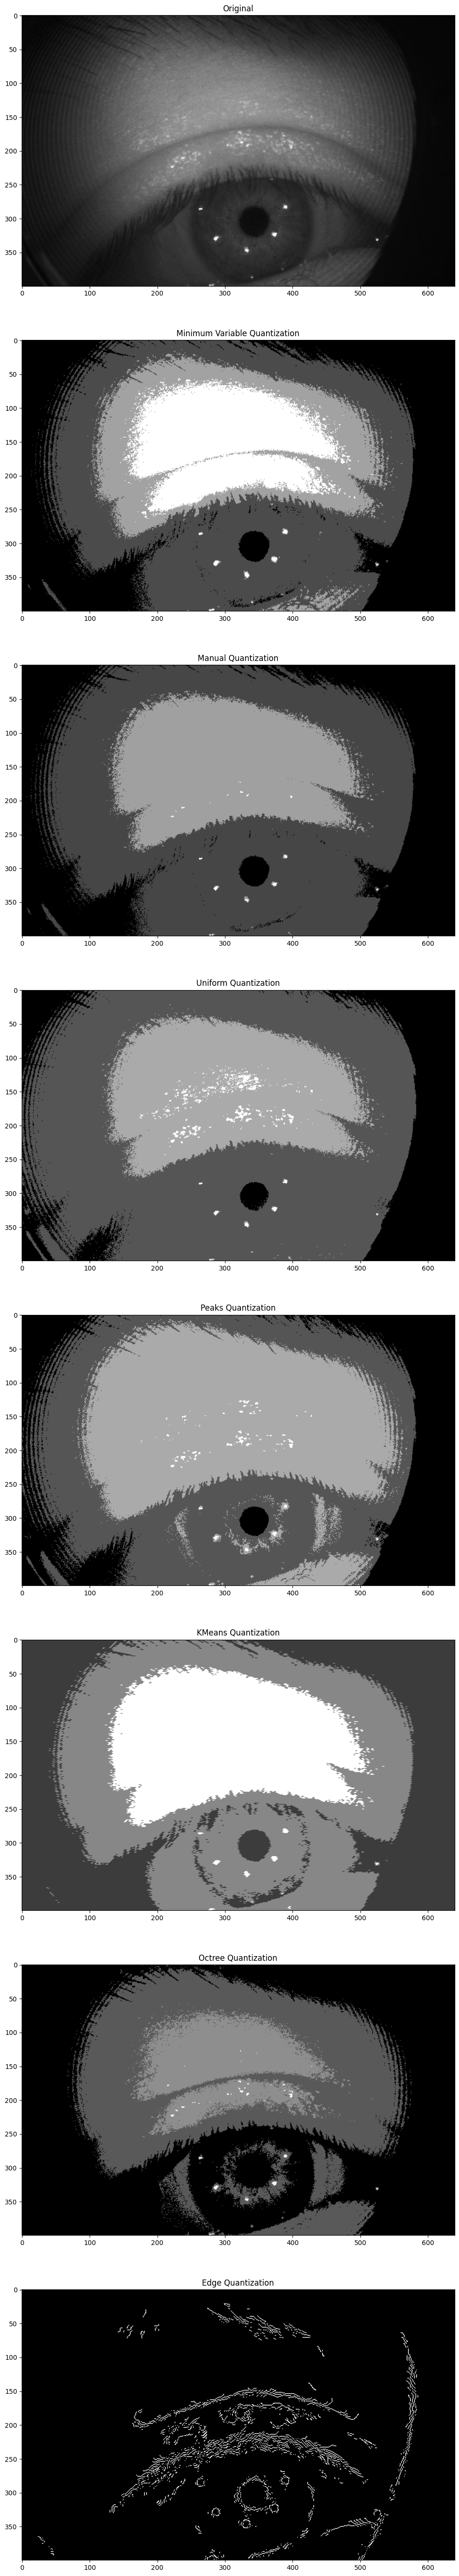

In [44]:
img_path = '/mnt/sdb/data/Openedsdata2020/openEDS2020-GazePrediction/train/sequences/6624/005.png'
img_numpy = plt.imread(img_path)
img_torch = io.read_image(img_path).to(torch.uint8)[0]
img_cv2 = cv2.imread(img_path)
img_cv2 = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2GRAY)

fig = plt.figure(figsize=(100, 70)) 
rows = 8
columns = 1

fig.add_subplot(rows, columns, 1) 
plt.imshow(img_numpy, cmap='gray')
plt.title("Original") 

fig.add_subplot(rows, columns, 2) 
plt.imshow(min_var_quant(img_numpy, 2), cmap='gray')
plt.title("Minimum Variable Quantization") # same algorithm as otsu quantization

fig.add_subplot(rows, columns, 3) 
plt.imshow(manual_quant(img_torch), cmap='gray')
plt.title("Manual Quantization") 

fig.add_subplot(rows, columns, 4) 
plt.imshow(uniform_quant(img_torch), cmap='gray')
plt.title("Uniform Quantization") 

fig.add_subplot(rows, columns, 5) 
plt.imshow(peak_quant(img_torch), cmap='gray')
plt.title("Peaks Quantization") 

fig.add_subplot(rows, columns, 6) 
plt.imshow(kmeans_quant(img_torch), cmap='gray')
plt.title("KMeans Quantization") 

fig.add_subplot(rows, columns, 7) 
plt.imshow(octree_quant(img_torch, 2), cmap='gray')
plt.title("Octree Quantization") 

fig.add_subplot(rows, columns, 8) 
plt.imshow(edge(img_cv2), cmap='gray')
plt.title("Edge Quantization") 


In [10]:
quant_scheme = 'uniform'

for data_type in ['train', 'validation', 'test']:
	datatype_dir = os.path.join(data_dir, data_type, 'sequences')
	for directory in os.listdir(datatype_dir):
		for img_file in os.listdir(os.path.join(datatype_dir, directory)):
			img_path = os.path.join(datatype_dir, directory, img_file)
			img = io.read_image(img_path).to(torch.uint8)[0]

			match quant_scheme:
				case 'uniform':
					img = uniform_quant(img)

				case 'manual':
					img = manual_quant(img)

				case 'peaks':
					img = peak_quant(img)

				case 'kmeans':
					img = kmeans_quant(img)
					
			img = np.where(img == img.max(), 255, img).astype(np.uint8)

			out_temp_dir = os.path.join(out_dir, data_type, 'sequences', directory)
			print(img_file, out_temp_dir)
			if not os.path.isdir(out_temp_dir):
				os.system(f'mkdir -p {out_temp_dir}')
			out_img_path = os.path.join(out_temp_dir, img_file)

			img = Image.fromarray(img)
			# img.save(out_img_path)

			# utils.save_image(img, out_img_path)
			# plt.imshow(img.reshape(img.shape[1:]), cmap='gray')
			break
		break
	break


046.png /mnt/sdb/data/Openedsdata2020/openEDS2020-GazePrediction-2bit/train/sequences/6624


AttributeError: 'Image' object has no attribute 'reshape'